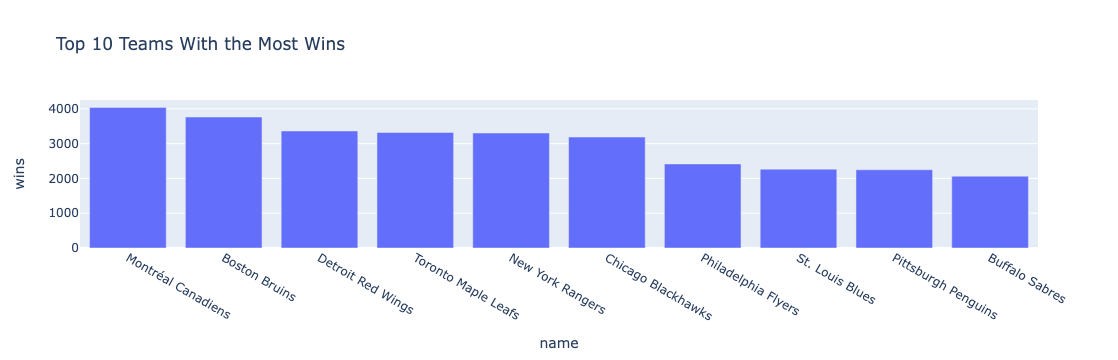

In [37]:
from dagster import asset

import plotly.express as px
import plotly.io as pio

import duckdb
import os

# from . import constants

query = """
    WITH home_games AS (
        select 
            id,
            homeTeamId as teamId,
            homeScore as teamScore,
            visitingScore as opponentScore,
            CASE
                WHEN homeScore > visitingScore THEN 'win'
                WHEN homeScore < visitingScore THEN 'loss'
                ELSE 'tie'
            END AS result
        from raw_nhl_games
        ),
     away_games AS (
         select
            id,
            visitingTeamId as teamId,
            homeScore as opponentScore,
            visitingScore as teamScore,
            CASE
                WHEN visitingScore > homeScore THEN 'win'
                WHEN visitingScore < homeScore THEN 'loss'
                ELSE 'tie'
            END AS result
        from raw_nhl_games),
    games as (
        select id, teamId, teamScore, opponentScore, result from home_games
        UNION ALL
        select id, teamId, teamScore, opponentScore, result from away_games)

    select 
        games.teamId,
        ANY_VALUE(teams.fullName) as name,
        count(CASE WHEN games.result = 'win' THEN games.id END) as wins
    from games
    LEFT JOIN raw_nhl_teams as teams
    ON games.teamId = teams.id
    group by games.teamId
    order by wins desc
    limit 10
"""

#conn = duckdb.connect(os.getenv("DUCKDB_DATABASE"))

cursor = duckdb.connect('/home/dpage/Projects/skrimmage/data/staging/data.duckdb')
results = cursor.execute(query).fetch_df()
cursor.close()

#results.head()

fig = px.bar(results, x='name', y='wins', title="Top 10 Teams With the Most Wins")
fig.show()